# Test rotation MNIST

In [1]:
import os
import jax
import optax
import dynamax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn

import seaborn as sns
import matplotlib.pyplot as plt
from dynamax.utils import datasets
from itertools import product
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable, Tuple
from jaxtyping import Array, Float, Int
from flax.training.train_state import TrainState

In [2]:
%config InlineBackend.figure_format = "retina"

## Rotation

In [3]:
np.random.seed(314)
num_train = 100

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X = jnp.array(X_train)[:num_train]
y = jnp.array(y_train)[:num_train]

ix_sort = jnp.argsort(y)
X = X[ix_sort]
y = y[ix_sort]

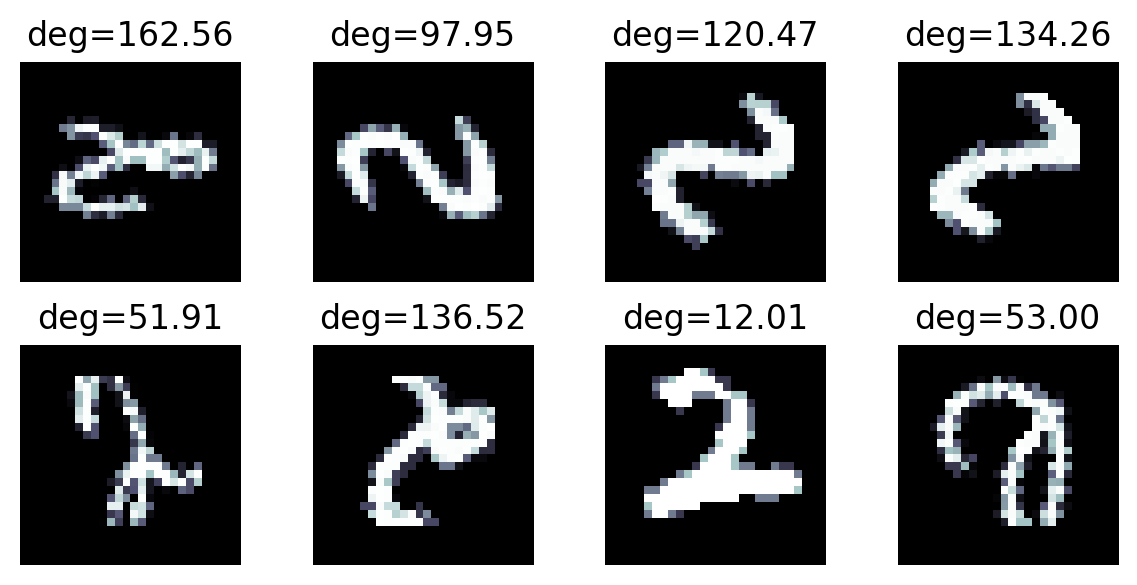

In [4]:
np.random.seed(314)
n_test = 8
ixs_test = np.random.randint(0, len(X_train), size=n_test)

fig, axs = plt.subplots(2, 4, figsize=(6, 3))
axs = axs.ravel()
for ax, ix in zip(axs, ixs_test):
    img = X_train[ix]
    deg = y_train[ix]
    ax.imshow(img.reshape(28, 28), cmap="bone")
    ax.axis("off")
    ax.set_title(f"{deg=:0.2f}")
plt.tight_layout()

# Training

## Setup

In [5]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(200)(x)
        x = self.activation(x)
        x = nn.Dense(200)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x


@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    yhat = applyfn(params, X)
    mll = (y - yhat.ravel()) ** 2
    return mll.mean()


@partial(jax.jit, static_argnames=("loss_grad",))
def train_step(
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    ixs: Int[Array, "batch_len"],
    state: TrainState,
    loss_grad: Callable,
) -> Tuple[float, TrainState]:
    """
    Perform a single training step.
    The `loss_grad` function
    """
    X_batch = X[ixs]
    y_batch = y[ixs]
    loss, grads = loss_grad(state.params, X_batch, y_batch, state.apply_fn)    
    state = state.apply_gradients(grads=grads)
    return loss, state

In [6]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [7]:
model = MLP(1)
batch_init = jnp.ones((10, 28 ** 2))
params_init = model.init(key_init, batch_init)

In [8]:
buffer_size = 10 # Batch size
num_epochs = 500

## Vanilla SGD

In [9]:
@partial(jax.jit, static_argnums=(1,2))
def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(
    key: int,
    batch_size: int,
    state: TrainState,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    loss_grad: Callable,
):
    num_train = X.shape[0]
    loss_epoch = 0.0
    train_ixs = get_batch_train_ixs(key, num_train, batch_size)
    for ixs in train_ixs:
        loss, state = train_step(X, y, ixs, state, loss_grad)
        loss_epoch += loss
    return loss_epoch, state

In [10]:
num_epochs = 400
batch_size = 100
keys_train = jax.random.split(key_train, num_epochs)
loss_grad = jax.value_and_grad(lossfn, 0)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-4)
)

losses = []
crossval = []

elements  = list(enumerate(keys_train))
pbar = tqdm(elements)
for (e, key) in pbar:
    loss, state, = train_epoch(key, batch_size, state, X, y, loss_grad)
    losses.append(loss)
    
    xv_test = lossfn(state.params, X_test, y_test, state.apply_fn)
    crossval.append(xv_test.item())

    losstr = f"{loss:0.4e}"
    pbar.set_description(losstr)

  0%|          | 0/400 [00:00<?, ?it/s]

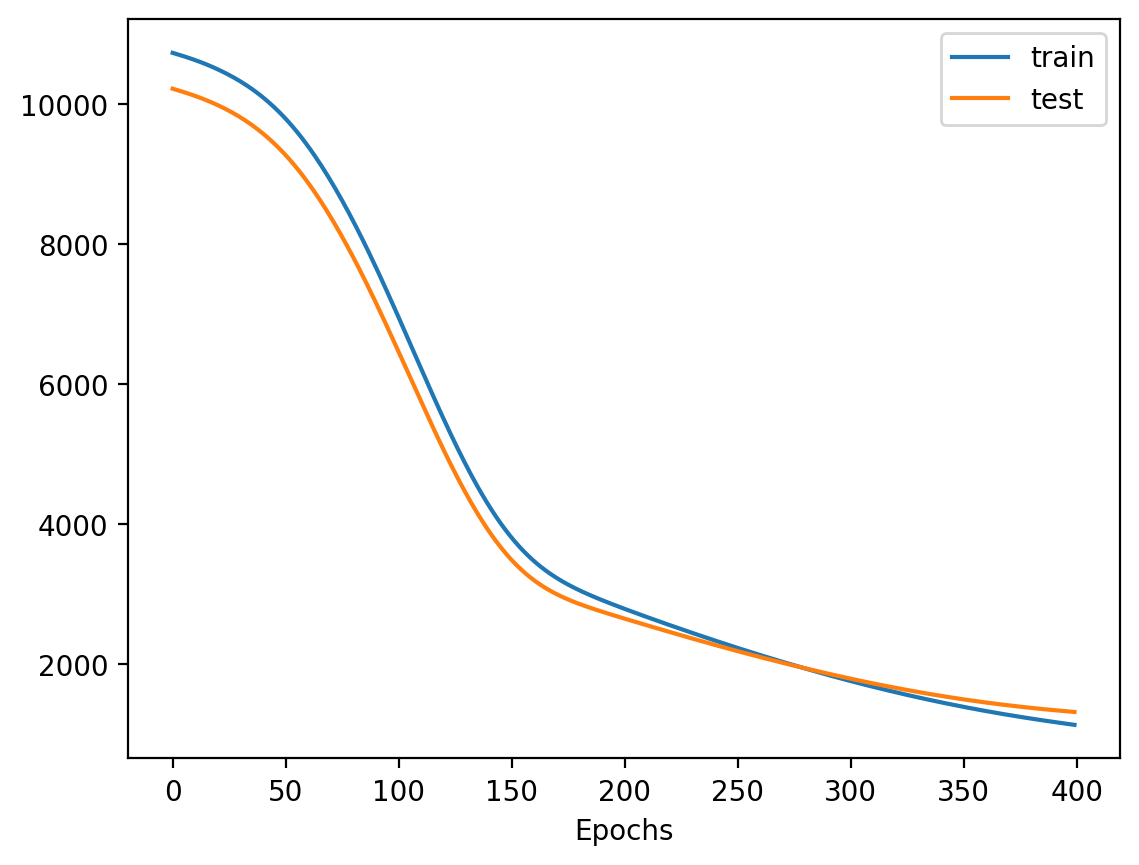

In [11]:
plt.plot(losses, label="train")
plt.plot(crossval, label="test")
plt.legend()
plt.xlabel("Epochs");

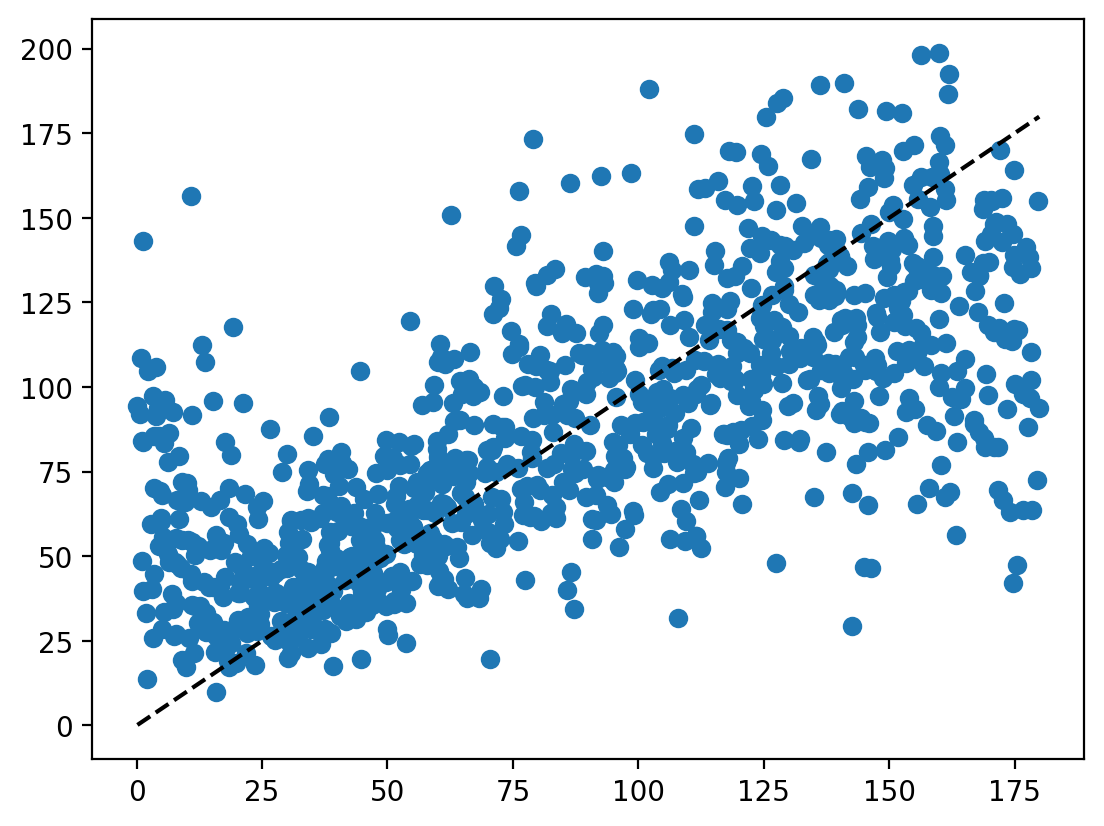

In [12]:
vmin, vmax = y_test.min(), y_test.max()
yhat_test = state.apply_fn(state.params, X_test).ravel()

plt.scatter(y_test, yhat_test)
plt.plot([vmin, vmax], [vmin, vmax], c="black", linestyle="--")

In [13]:
sgd_loss = lossfn(state.params, X_test, y_test, state.apply_fn).item()

## Replay buffer FIFO

Consider a buffer with size 4, the minibatches are given by
```
[x0,]
[x0, x1]
[x0, x1, x2]
[x0, x1, x2, x3]
[x1, x2, x3, x4]
[x2, x3, x4, x5]
[x3, x4, x5, x6]
...
```

In [14]:
@partial(jax.jit, static_argnames=("buffer_size",))
def get_fifo_batches(ix, buffer_size):
    ix_lookback = (ix - buffer_size) + 1
    batches = jnp.arange(buffer_size) + ix_lookback
    return batches


@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, X, y, ixs, applyfn):
    X_batch, y_batch = X[ixs], y[ixs]
    counter = (ixs >= 0)
    
    yhat = applyfn(params, X_batch).ravel()
    loss = (y_batch - yhat) ** 2
    loss = (loss * counter).sum() / counter.sum()
    return loss
    

@partial(jax.jit, static_argnames=("loss_grad",))
def train_step_fifo(
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs dim_obs"],
    ixs: Int[Array, "batch_len"],
    state: TrainState,
    loss_grad: Callable,
) -> Tuple[float, TrainState]:
    """
    """
    loss, grads = loss_grad(state.params, X, y, ixs, state.apply_fn)
    state = state.apply_gradients(grads=grads)
    return loss, state

loss_grad = jax.value_and_grad(lossfn_fifo, argnums=0)

In [15]:
buffer_size = 10
num_train = 100

In [16]:
def train_xval_fifo(
    state_init,
    X,
    y,
    Xcv,
    ycv,
    loss_grad,
    lossfn_test,
    buffer_size: int = 10,
    n_inner: int = 1,
    leave=True,
):
    losses_train, losses_xv = [], []
    state = state_init.replace()
    
    elements = range(num_train)
    pbar = tqdm(elements, leave=leave)
    for ix in pbar:
        ixs = get_fifo_batches(ix, buffer_size)
        for _ in range(n_inner):
            loss_train, state = train_step_fifo(X, y, ixs, state, loss_grad)
        losses_train.append(loss_train)
        
        loss_xv = lossfn_test(state.params, Xcv, ycv, state.apply_fn)
        losses_xv.append(loss_xv)
        
        losstr = f"{loss:0.4e}"
        pbar.set_description(losstr)
    return state, (losses_train, losses_xv)

In [17]:
n_inner_list = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 100]
buffer_size_list = [1, 5, 10, 15, 20, 25, 50, 100]
n_buffers = len(buffer_size_list)

losses_df = []
elements = list(product(n_inner_list, buffer_size_list))
pbar = tqdm(elements)
for (n_inner, buffer_size) in pbar:
    state = TrainState.create(
        apply_fn=model.apply,
        params=params_init,
        tx=optax.adam(1e-4)
    )
    
    state, losses = train_xval_fifo(
        state, X, y, X_test, y_test, loss_grad, lossfn,
        buffer_size=buffer_size, n_inner=n_inner,
        leave=False
    )
    
    train_losses, test_losses = losses
    entries = [{
        "n_obs": n_obs,
        "buffer_size": buffer_size,
        "n_inner_its": n_inner,
        "loss": loss.item()
    } for n_obs, loss in enumerate(test_losses)]
    losses_df.extend(entries)
losses_df = pd.DataFrame(losses_df)

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Log-RMSE — Test set')

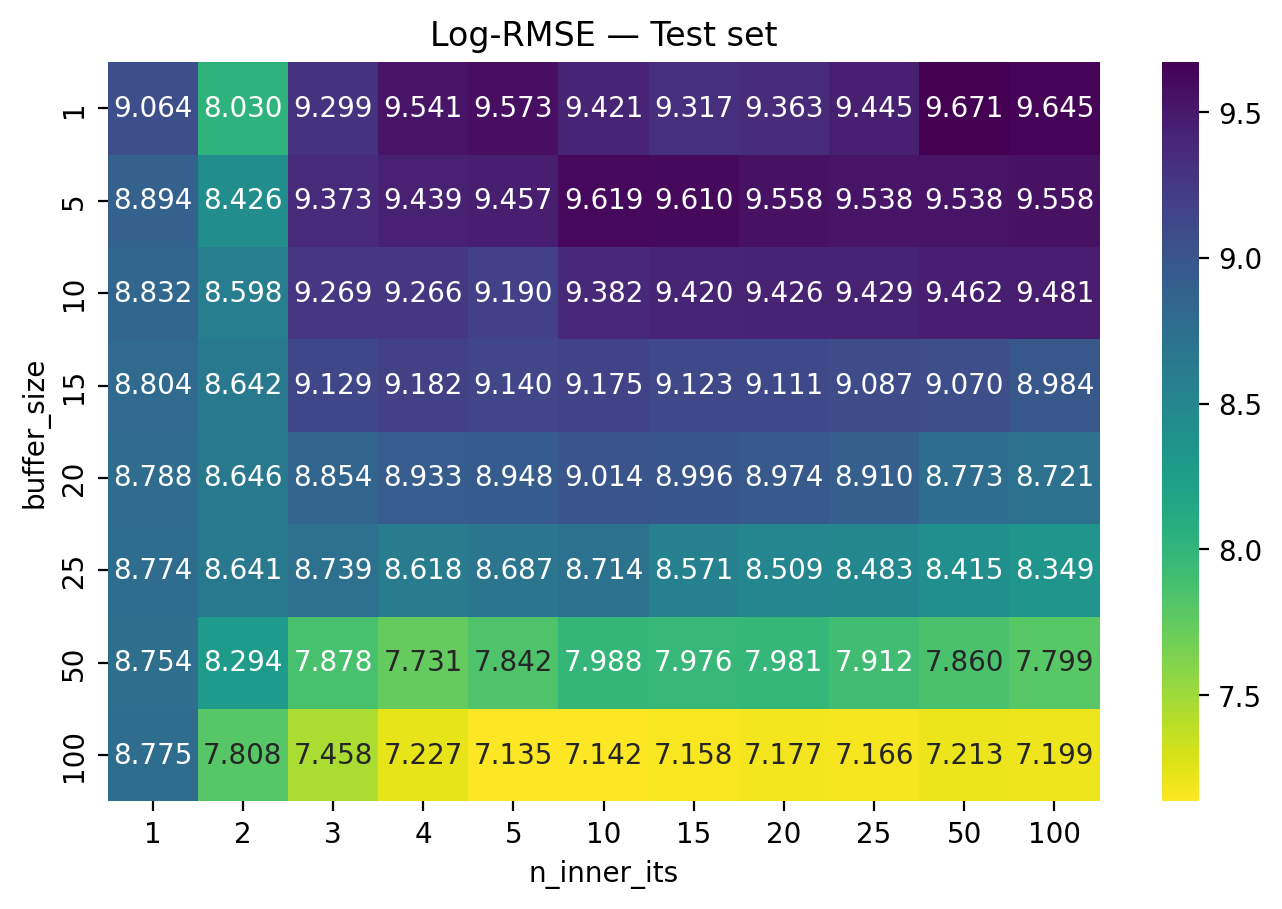

In [18]:
fig, ax = plt.subplots(figsize=(8, 4.8))
group = losses_df.query("n_obs == 99").pivot_table(index="buffer_size", columns="n_inner_its", values="loss")
sns.heatmap(np.log(group), cmap="viridis_r", annot=True, fmt="0.3f", ax=ax)
plt.title("Log-RMSE — Test set")

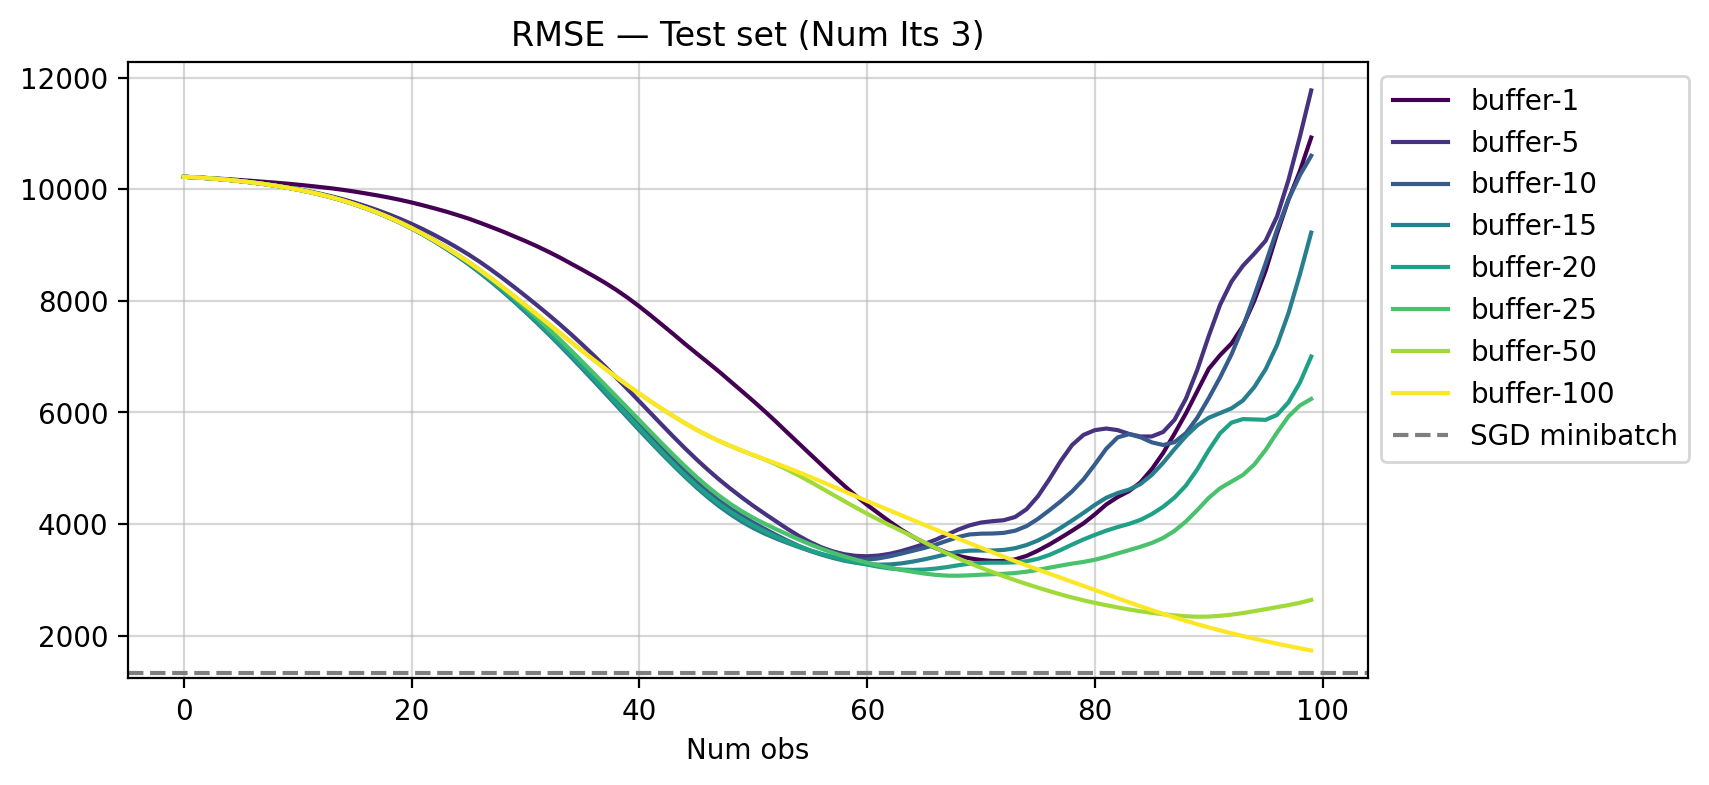

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
n_inner = 3
colors = plt.cm.viridis(np.linspace(0, 1, n_buffers))

for c, buffer_size in zip(colors, buffer_size_list):
    query = f"(n_inner_its==@n_inner) & (buffer_size==@buffer_size)"
    subset = losses_df.query(query).set_index("n_obs")["loss"]
    subset.plot(label=f"buffer-{buffer_size}", color=c)
plt.xlabel("Num obs")
plt.title(f"RMSE — Test set (Num Its {n_inner})")
plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.5)

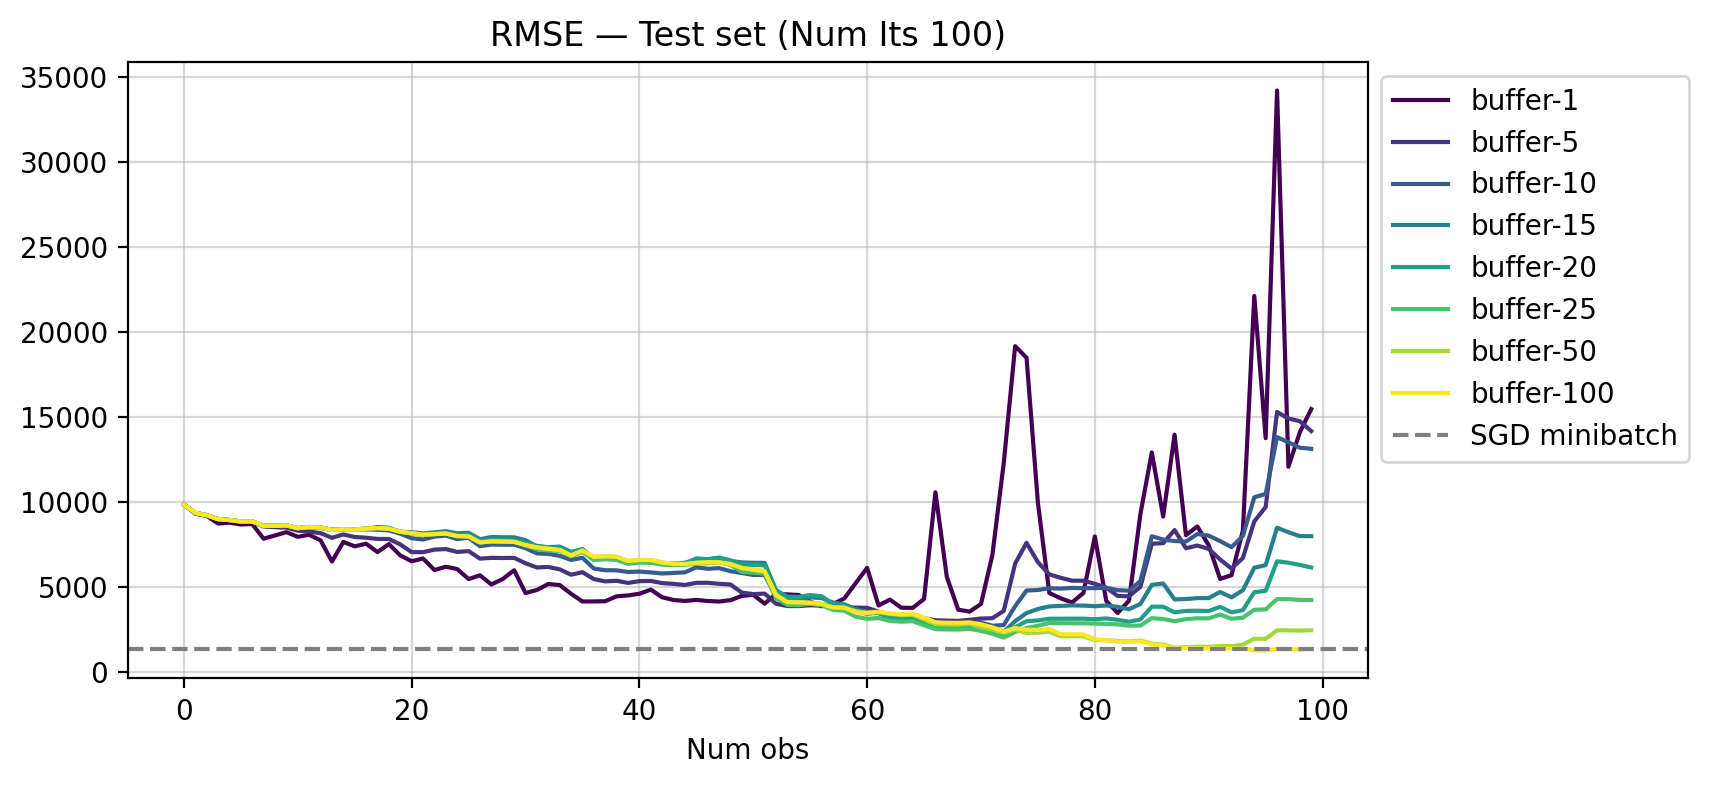

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
n_inner = 100
colors = plt.cm.viridis(np.linspace(0, 1, n_buffers))

for c, buffer_size in zip(colors, buffer_size_list):
    query = f"(n_inner_its==@n_inner) & (buffer_size==@buffer_size)"
    subset = losses_df.query(query).set_index("n_obs")["loss"]
    subset.plot(label=f"buffer-{buffer_size}", color=c)
plt.xlabel("Num obs")
plt.title(f"RMSE — Test set (Num Its {n_inner})")
plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.5)